 # Homework 6
 ## Group 10

## Assignment 1 - Reviews

We review the homeworks for groups 15 and 32.

## Assignment 2 - CIFAR-10 Classification

## READ ME

This notebook does not work like a standard notebook. It is instead dynamic, allowing you to decide what optimization techniques (or combinations of them) you wish to apply. Follow the instructions in bold throughout this sheet to ensure you do not miss any required cells and that you fully understand your options (the menu) for each customizable section.

**Run all of the following cells until you encounter a menu option instruction.**

In [1]:
# the necessary imports

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime as datetime
import tqdm
import keras_cv # install keras_cv with pip for data augmentation

In [2]:
def preprocess(dataset):

        # convert data from uint8 to float32
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, target: ((img / 128.) - 1., target))

    # create one-hot targets with depth 10 since cifar 10 has 10 classes
    dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # cache
    dataset = dataset.cache()

    # shuffle, batch, prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) 

    # return preprocessed dataset
    return dataset

In [3]:
(train_ds, test_ds), ds_info = tfds.load ('cifar10', split =['train', 'test'], as_supervised = True, with_info = True)

In [4]:
train_dataset = preprocess(train_ds)
test_dataset = preprocess(test_ds)

**If you would like to see a readout and/or examples from the dataset, run the cell below.**

In [ ]:
# get a readout of the dataset info
print("ds_info: \n", ds_info)

# visualize a sample of the dataset
tfds.show_examples(train_ds, ds_info)

**Run the following cell regardless. It defines the basic CNN model we will be using. Don't worry, you'll get to play around with optimization options for it later. :)**

In [5]:
class ConvModel(tf.keras.Model):
    def __init__(self, L1_reg=0, L2_reg=0, dropout_rate=0, batch_norm=False):
        super().__init__()

        self.dropout_rate = dropout_rate
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam()
        
        if L2_reg >= 0: # L2 is the default
            kernel_regularizer=tf.keras.regularizers.L2(L2_reg)
        elif L1_reg > 0: 
            kernel_regularizer=tf.keras.regularizers.L2(L1_reg)
        else:
            None

        if self.dropout_rate:
            self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
    
        # input 32x32x3 with 3 as the color channels
        if batch_norm:
            self.layer_list = [tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer),
                               tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Conv2D(32, 3,activation="relu", kernel_regularizer=kernel_regularizer),
                               tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer),
                               tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer),
                               tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.GlobalAvgPool2D(),
                                tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=kernel_regularizer)]

        else:
            self.layer_list = [tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), # 32x32x32
                                tf.keras.layers.Conv2D(32, 3,activation="relu", kernel_regularizer=kernel_regularizer), # 32x32x32
                                tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), # 32x32x32
                                tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), # 32x32x32
                                tf.keras.layers.GlobalAvgPool2D(),
                                tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=kernel_regularizer)]

        self.metrics_list = [ 
                    tf.keras.metrics.Mean(name="total_frobenius_norm"),
                    tf.keras.metrics.Mean(name="loss"),
                    tf.keras.metrics.CategoricalAccuracy(name="acc"),
                    ]
    @tf.function
    def call(self, x, training=False):
        for layer in self.layer_list[:-1]:
            x = layer(x)
            if self.dropout_rate:
                x = self.dropout_layer(x, training)

        return self.layer_list[-1](x)

    @property
    def metrics(self):
        return self.metrics_list
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
            
    def compute_frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm
    
    @tf.function
    def train_step(self, data):

        img, label = data

        with tf.GradientTape() as tape:
            prediction = self(img, training=True)
            loss = self.loss_function(label, prediction)
            # loss = self.compiled_loss(target, prediction, regularization_losses=self.losses)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.metrics[0].update_state(self.compute_frobenius())
        self.metrics[1].update_state(loss)
        self.metrics[2].update_state(label, prediction)
        
        return {metric.name: metric.result() for metric in self.metrics}
    
    @tf.function
    def test_step(self, data):

        img, label = data

        prediction = self(img, training=False)
        loss = self.loss_function(label, prediction)
        # loss = self.compiled_loss(target, prediction, regularization_losses=self.losses)

        self.metrics[0].update_state(self.compute_frobenius())
        self.metrics[1].update_state(loss)
        self.metrics[2].update_state(label, prediction)
        
        return {metric.name: metric.result() for metric in self.metrics}

### First Course - In-Model Optimization Options

**You have 5 options for this part of the menu:**

**- Option 1: the basic model w/ no optimizations applied**
**- Option 2: the basic model w/ L1 regularization**
**- Option 3: the basic model w/ L2 regularization**
**- Option 4: the basic model w/ dropout layers**
**- Option 5: the basic model w/ batch normalization**

**Run the cell corresponding to your choice and then proceed with the sheet.**

*Note - this section and the model code above fulfill part 2.2 of the assignment.*

In [6]:
# Option 1 - Plane Jane

network = ConvModel() 

In [143]:
# Option 2 - Lovin' L1

network = ConvModel(L1_reg=0.001) 

In [146]:
# Option 3 - Lovin' L2

network = ConvModel(L2_reg=0.001) 

In [82]:
# Option 4 - Drop It

network = ConvModel(dropout_rate=0.5) 

In [96]:
# Option 5 - Nabbin' the Norm

network = ConvModel(batch_norm=True)

**Run the next cell regardless. It sets up the logging and metrics we'll need for visualization later.**

In [7]:
# Initiate the logs and metrics
config_name= "HW06"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time}/train"
val_log_path = f"logs/{config_name}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)

# Initiate epochs and learning rate as global variables
epochs = 15
learning_rate = 0.05

# Define arrays for saving values for later visualization
train_forb_norm = []
train_losses = []
train_accuracies = []

val_forb_norm = [] 
val_losses = []
val_accuracies = []

**Run the following cells regardless. They prepare the training options you will choose between later.**

In [76]:
def training(network):

    '''
    :param network: the network model to be trained
    '''

    # Train the model
    for epoch in range(epochs):
        print(f"Epoch: {epoch}, optimizer: {network.optimizer}")

        for data in tqdm.tqdm(train_dataset, position=0, leave=True):
            metrics = network.train_step(data)

            with train_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics
        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of metrics
        for (key, value) in metrics.items():
            if key == "total_frobenius_norm":
                train_forb_norm.append(value.numpy())
            elif key == "loss":
                train_losses.append(value.numpy())
            elif key == "acc":
                train_accuracies.append(value.numpy())
            else:
                None

        # reset metrics for next round
        network.reset_metrics()

        # Testing
        for data in test_dataset:
            metrics = network.test_step(data)

            # log the accs and losses
            with val_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        # print the metrics
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of metrics
        for (key, value) in metrics.items():
            if key == "total_frobenius_norm":
                val_forb_norm.append(value.numpy())
            elif key == "loss":
                val_losses.append(value.numpy())
            elif key == "acc":
                val_accuracies.append(value.numpy())
            else:
                None

        # reset all metrics
        network.reset_metrics()

In [10]:
def training_es(network):

    '''
    :param network: the network model to be trained
    '''

    # define a counter for the number of epochs when the validation loss increased
    lossincreasecount = 0

    # define how many epochs you will run for at the start before caring whether validation loss is increasing
    guaranteedepochs = 1

    # define how many consecutive epochs you will tolerate the validation loss increasing for before halting training
    tolerableincreaseepochs = 1

    # Train the model
    for epoch in range(epochs):

        # always run training for the guaranteed number of epochs defined above
        if epoch < guaranteedepochs:
            print('gauranteed epoch')
            print(f"Epoch: {epoch}, optimizer: {network.optimizer}")

            for data in tqdm.tqdm(train_dataset, position=0, leave=True):
                metrics = network.train_step(data)

                with train_summary_writer.as_default():
                    for metric in network.metrics:
                        tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

            # print the end acc and loss
            print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

            # make a list of metrics
            for (key, value) in metrics.items():
                if key == "total_frobenius_norm":
                    train_forb_norm.append(value.numpy())
                elif key == "loss":
                    train_losses.append(value.numpy())
                elif key == "acc":
                    train_accuracies.append(value.numpy())
                else:
                    None

            # reset metrics for next round
            network.reset_metrics()

            # Testing
            for data in test_dataset:
                metrics = network.test_step(data)

                # log the accs and losses
                with val_summary_writer.as_default():
                    for metric in network.metrics:
                        tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

            # print the end acc and loss
            print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

            # make a list of metrics
            for (key, value) in metrics.items():
                if key == "total_frobenius_norm":
                    val_forb_norm.append(value.numpy())
                elif key == "loss":
                    val_losses.append(value.numpy())
                elif key == "acc":
                    val_accuracies.append(value.numpy())
                else:
                    None

            # reset all metrics
            network.reset_metrics()

        # after the guaranteed number of epochs, start monitoring val loss to determine when training should stop
        else:
            print(f"Epoch: {epoch}, optimizer: {network.optimizer}")

            for data in tqdm.tqdm(train_dataset, position=0, leave=True):
                metrics = network.train_step(data)

                with train_summary_writer.as_default():
                    for metric in network.metrics:
                        tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

            # print the end acc and loss
            print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])
            
            # make a list of metrics
            for (key, value) in metrics.items():
                if key == "total_frobenius_norm":
                    train_forb_norm.append(value.numpy())
                elif key == "loss":
                    train_losses.append(value.numpy())
                elif key == "acc":
                    train_accuracies.append(value.numpy())
                else:
                    None

            # reset metrics for next round
            network.reset_metrics()

            # Testing
            for data in test_dataset:
                metrics = network.test_step(data)

                # log the accs and losses
                with val_summary_writer.as_default():
                    for metric in network.metrics:
                        tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

            # print the end acc and loss
            print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

            # make a list of metrics
            for (key, value) in metrics.items():
                if key == "total_frobenius_norm":
                    val_forb_norm.append(value.numpy())
                elif key == "loss":
                    val_losses.append(value.numpy())
                elif key == "acc":
                    val_accuracies.append(value.numpy())
                else:
                    None
                    
            # reset all metrics
            network.reset_metrics()

            # if you see the validation loss increasing for more than a set amount of consecutive epochs, terminate training
            if val_losses[epoch]>val_losses[epoch-1] and lossincreasecount == tolerableincreaseepochs:
                print('val loss still increasing beyond tolerated epoch number, halting training. Last loss was ' + str(val_losses[epoch]) + '.')
                break

            if val_losses[epoch]>val_losses[epoch-1] and lossincreasecount != tolerableincreaseepochs:
                lossincreasecount=++1
                print('val loss has increased for ' + str(lossincreasecount) + ' epochs. Last loss was ' + str(val_losses[epoch]) + '.')

            elif val_losses[epoch]<=val_losses[epoch-1]:
                print('val loss decreased or stayed the same, continuing')
                lossincreasecount = 0




### Second Course - Training Options

**You have two options for this part of the menu:**

**- Option 1: standard training**
**- Option 2: training that implements early stopping**

**Run the cell corresponding to your choice and then proceed with the sheet.**

**If you would like to monitor the training in the TensorBoard, run the cell immediately following this message.**

*Note - this section fulfills part 2.3 of the assignment.*

In [ ]:
# prepare the tensorboard ahead of training

%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
# Option 1 - The Usual

training(network)

In [ ]:
# Option 2 - The Early Bird

training_es(network)

### The Restaurant Review - Visualization

**Run the cell below to see how the model performed with the selected menu options.**

*Note - this section fulfills part 2.4 of the assignment.*

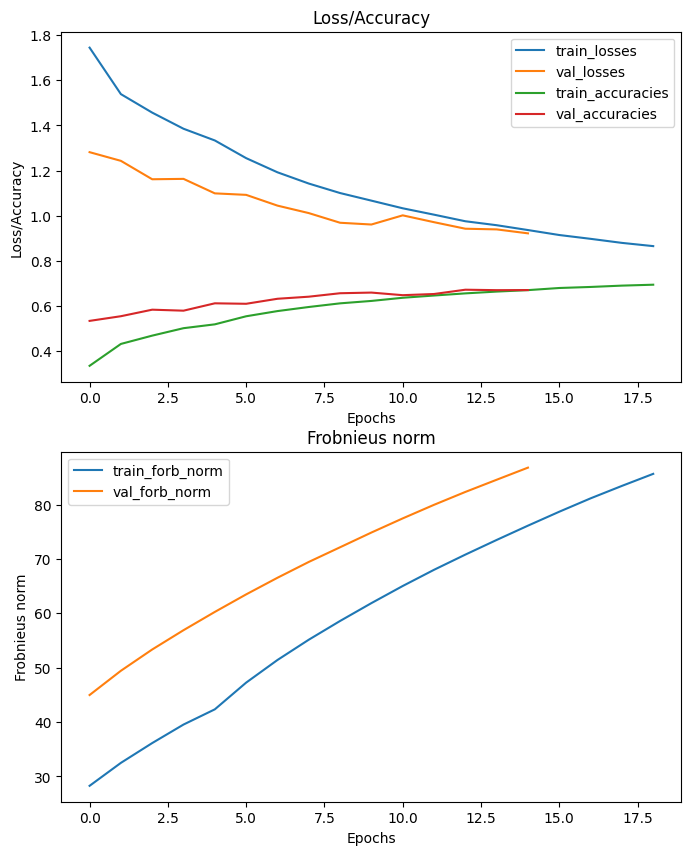

In [12]:
# visualize the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.set_title("Loss/Accuracy")
ax1.plot(train_losses, label='train_losses')
ax1.plot(val_losses, label='val_losses')
ax1.plot(train_accuracies, label='train_accuracies')
ax1.plot(val_accuracies, label='val_accuracies')

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss/Accuracy")
ax1.legend()

ax2.set_title("Frobnieus norm")
ax2.plot(train_forb_norm, label='train_forb_norm')
ax2.plot(val_forb_norm, label='val_forb_norm')

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Frobnieus norm")
ax2.legend()

# fig.savefig("CNN Original")
# fig.savefig("CNN L1")
# fig.savefig("CNN L2")
# fig.savefig("CNN Dropout")
# fig.savefig("CNN BatchNorm")
fig.savefig("CNN EarlyStop")

plt.show()

## Overfitting Report

Our original model overfit the data, as evidenced by the plateau in validation (testing) performance versus training. This discrepancy indicates it began to use features in the training data which did not help it generalize when it saw the new data in the test batch.

## Optimization Report

We attempted the following optimization techniques and report on our reasoning for them and the results we obtained with them below:

L1 (Lasso) Regularization:
- *Why?*: This regularization technique adds the absolute value of the coefficients to the loss function in order to penalize large weights that could contribute to overfitting (overreliance on certain features that might not actually be useful when generalizing to unseen data). We used this with our data because images present many features which could be relied on that might not help when working with new images even in the same class.
- *Observations*: With L1 regularization applied, our model's validation loss continued to decrease steadily at roughly the same pace as its training loss.

L2 (Ridge) Regularization:
- *Why?*: This regularization technique adds the squared magnitude of the coefficients to the loss function in order to penalize large weights that could contribute to overfitting (overreliance on certain features that might not actually be useful when generalizing to unseen data). We used this with our data because images present many features which could be relied on that might not help when working with new images even in the same class.
- *Observations*: With L2 regularization applied, our model's validation loss continued to decrease steadily at roughly the same pace as its training loss.

Dropout:
- *Why?*: This technique "drops out" a certain number of units from targeted layers, meaning not all units get trained on each epoch. This does not allow all units to shift when faced with new data and in aggregate, the units come to represent a better understanding of the underlying data since they were not all able to train on the same inputs and therefore could not all simply memorize the exact data they trained on.
- *Observations*: With dropout applied, our model's validation loss did not begin increasing later in training.

Batch Normalization:
- *Why?*: This technique recenters and realigns the data between two layers, which combats overfitting by forcing the next layer to work with the pattern in the data and not the data points themselves (which might have features that do not generalize well).
- *Observations*: With batch normalization applied, our model's validation loss did not begin increasing later in training.

Early Stopping :
- *Why?*: This technique halts training when validation loss starts to increase, an indication that the model has started to fit elements of the training data (ex. noise) that are not helping it generalize to unseen data. By halting early, the ultimate model is often a better model of the actual underlying patterns in the data than a model that further trained on that data and came to represent it too finely to generalize to new data in the same class or distribution.
- *Observations*: Our model did not always stop training at the same epoch, since in some runs validation loss kept decreasing while in others it appeared to start using non-generalizing features earlier on, resulting in the validation loss beginning to increase sooner. The effectiveness of this technique depended a great deal on how training progressed. If it happened to progress such that the loss kept decreasing over the epochs, there was no effect, but on runs where the loss began increasing again, this techinque prevented the model from reaching a poorly performing state it would otherwise have reached with standard training.

Plots for the results of our runs with the above techniques applied can be found in the "plot for hw6" folder.
